# Airbnb Data Analysis Project Report

## Introduction

## Dataset Overview
Calendar
The calendar file contains information about the availability and price of listings on different dates. It includes the following columns:

listing_id: The unique identifier of the listing.
date: The date for which the availability and price information is provided.
available: A binary value indicating whether the listing is available (t for available, f for unavailable).
price: The price of the listing on the given date, in the local currency.
## Listings
The listings file provides detailed information about each listing. It includes various columns, such as:

id: The unique identifier of the listing.
name: The title or name of the listing.
host_id: The unique identifier of the host.
host_name: The name of the host.
neighbourhood: The name of the neighborhood where the listing is located.
room_type: The type of room available (e.g., Entire home/apt, Private room, Shared room).
price: The price per night for the listing.
minimum_nights: The minimum number of nights required for booking.
number_of_reviews: The total number of reviews for the listing.
review_scores_rating: The rating score of the listing based on reviews.
## Reviews
The reviews file contains detailed reviews for each listing. It includes the following columns:

listing_id: The unique identifier of the listing.
id: The unique identifier of the review.
date: The date when the review was posted.
reviewer_id: The unique identifier of the reviewer.
reviewer_name: The name of the reviewer.
comments: The text content of the review.
## Analysis
Availability and Pricing

Analyzed the availability of listings over time.
Explored the distribution of listing prices and identified any outliers.
Listing Characteristics

Investigated the distribution of different room types.
Explored the popular neighborhoods for Airbnb listings in Boston.
Analyzed the minimum number of nights required for booking.
Guest Feedback

Analyzed the number of reviews for each listing.
Investigated the review scores and ratings.
Explored the sentiments of guest comments.


In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Preprocessing
Upon analysing the dataset, we decided that only [listings.csv](airbnb/listings.csv) was suitable to be trained in the ANN model. We have dropped many of the irrelevant features and the remaining ones were used to train the prediction model. The target of this model is to predict the rent prices based on real world data from airbnb, in Boston, America.

In [2]:
# Load the preprocessing data
listing_data = pd.read_csv('./airbnb/listings.csv', sep=',')

# Dropping the irelevant features
drop = [
'id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 
'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 
'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 
'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_is_superhost', 'host_thumbnail_url', 
'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 
'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 
'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 
'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 
'room_type', 'square_feet', 'price', 
'has_availability', 'first_review', 'last_review', 
'license', 'jurisdiction_names']

# Prepare the feature matrix (X) and target variable (y)
X = listing_data.drop(drop, axis=1)
y = listing_data['price'].apply(lambda y: float(y.replace('$', '').replace(',', '')))

### Features
The features that were used to train this model are shown in X.keys(). Several data cleansing techniques were applied here to further preprocess the data. We decided to fill in the missing values with the mean since it is the most common technique.

In [3]:
X.keys()

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_verifications', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')

In [4]:
# Removing symbols from the categorical features
symbols = ['$', '/', '-', ',', '%']

X = X.replace(symbols, '', regex=True)

In [5]:
# One hot encoding for categorical features
X = pd.get_dummies(X)

In [6]:
# Fill the missing values for categorical columns
for column in X.select_dtypes(include='object'):
    X[column].fillna(X[column].mode()[0], inplace=True)

# Fill the missing values for numerical columns
X.fillna(X.mean().iloc[0], inplace=True)

## Building the model
Upon further testing, we decided that three hidden layers produces the best average prediction. When only one or two layers were used, the model overfits the data and the prediction was terrible. When more than three layers were used it either has no significant changes to the prediction or just overfits the data again. 

A normalisation layer was added to prevent shifting of the predicted price.

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
import tensorflow as tf

# ANN model with two hidden layers
tf_model = tf.keras.models.Sequential([
  tf.keras.layers.Normalization(axis=-1),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.7),

  # Add another layer here
  # Adding another layer restricts the prediction from going all over the place
  tf.keras.layers.Dense(128, activation='sigmoid'),
  tf.keras.layers.Dropout(0.7),
  
  # Add another layer here
  tf.keras.layers.Dense(256, activation='tanh'),
  tf.keras.layers.Dense(1)
])


In [9]:
from sklearn.linear_model import LinearRegression
import tensorflow as tf

# Compile the model
tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

In [10]:
# Fit the model
history = tf_model.fit(X_train_scaled, y_train, epochs=10, validation_split=0.3, verbose=0)

# Print the training and validation loss
print("Training loss:", history.history['loss'][-1])
print("Validation loss:", history.history['val_loss'][-1])

2023-06-27 22:12:27.205560: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Training loss: 9746.7109375
Validation loss: 11917.744140625


In [11]:
# Evalutate the model
loss = tf_model.evaluate(X_test_scaled, y_test)
print('Mean Squared Error: ', loss)

34/34 [==============================] - 0s 4ms/step - loss: 33557.5234
Mean Squared Error:  33557.5234375


### Prediction

In [12]:
# Make predictions
def post_process(predictions):
    predictions = np.where(predictions < 0, 0, predictions)
    return predictions

predictions = post_process(tf_model.predict(X_test_scaled))

34/34 [==============================] - 0s 2ms/step


In [13]:
# Print predictions
for i in range(20):
    print('Actual Price:', y_test.iloc[i], 'Predicted Price:' ' %.2f' % predictions[i][0])

Actual Price: 67.0 Predicted Price: 101.75
Actual Price: 299.0 Predicted Price: 299.09
Actual Price: 75.0 Predicted Price: 86.79
Actual Price: 219.0 Predicted Price: 296.21
Actual Price: 229.0 Predicted Price: 288.82
Actual Price: 99.0 Predicted Price: 104.59
Actual Price: 65.0 Predicted Price: 88.54
Actual Price: 319.0 Predicted Price: 301.82
Actual Price: 179.0 Predicted Price: 105.52
Actual Price: 695.0 Predicted Price: 297.68
Actual Price: 250.0 Predicted Price: 111.14
Actual Price: 298.0 Predicted Price: 295.91
Actual Price: 135.0 Predicted Price: 114.15
Actual Price: 70.0 Predicted Price: 91.78
Actual Price: 130.0 Predicted Price: 86.83
Actual Price: 65.0 Predicted Price: 112.42
Actual Price: 169.0 Predicted Price: 210.90
Actual Price: 295.0 Predicted Price: 217.57
Actual Price: 45.0 Predicted Price: 99.40
Actual Price: 130.0 Predicted Price: 186.00


### Visualisation

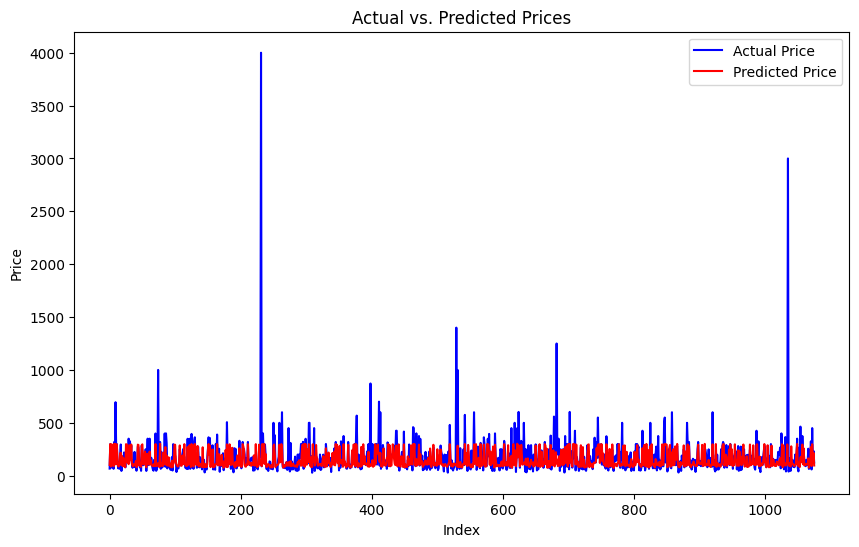

In [14]:
# Visualise using plt
import matplotlib.pyplot as plt

# Plotting the actual prices vs. predicted prices
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, color='blue', label='Actual Price')
plt.plot(range(len(predictions)), predictions, color='red', label='Predicted Price')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()

plt.show()

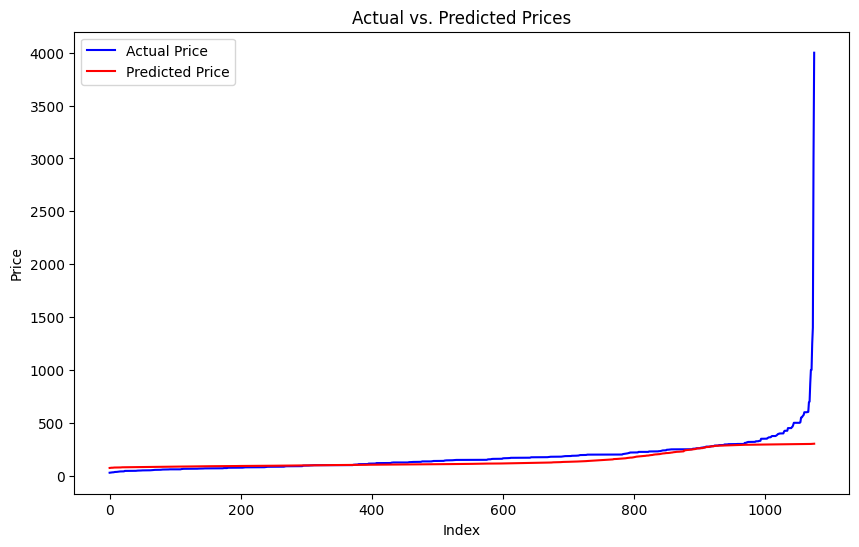

In [15]:
# Plotting in order

# Plotting the actual prices vs. predicted prices
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), sorted(y_test), color='blue', label='Actual Price')
plt.plot(range(len(predictions)), sorted(predictions), color='red', label='Predicted Price')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()

plt.show()